In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import nc_time_axis
import cftime
import glob

In [27]:
exptdict = OrderedDict([
    ('tx01-fc00',   {'expt':'tub-north-tx01-fc00','start_time':'1100-01-01'}),
    ('tx01-fc005',   {'expt':'tub-north-tx01-fc005','start_time':'1100-01-01'}),
    ('tx01-fc01',   {'expt':'tub-north-tx01-fc01','start_time':'1100-01-01'}),
    ('tx01-fc03',   {'expt':'tub-north-tx01-fc03','start_time':'1100-01-01'}),
    ('tx00-fc02',   {'expt':'tub-north-tx00-fc02','start_time':'1100-01-01'}),
    ('tx00-fc02-pert',   {'expt':'tub-north-tx00-fc02-pert','start_time':'1100-01-01'}),
    ('tx005-fc02',   {'expt':'tub-north-tx005-fc02','start_time':'1100-01-01'}),
    ('tx01-fc02',   {'expt':'tub-north-tx01-fc02','start_time':'1100-01-01'}),
    ('tx02-fc02',   {'expt':'tub-north-tx02-fc02','start_time':'1100-01-01'}),
    ('GM',   {'expt':'tub-north-GM-1deg','start_time':'1100-01-01'}),
    ('GM-tx00',   {'expt':'tub-north-GM-1deg-tx00','start_time':'1100-01-01'})
])
wind_expts = ['tx00-fc02-pert','tx005-fc02','tx01-fc02','tx02-fc02']
wind = [0, 0.05, 0.1, 0.2]
buoy_expts = ['tx01-fc00','tx01-fc005','tx01-fc01','tx01-fc02','tx01-fc03']
buoyancy = [0, 0.05, 0.1, 0.2, 0.3]
GM_expts = ['tx01-fc02','tx00-fc02','GM','GM-tx00']
processed = '/Users/andy/Code/buoyancy-gyres/tub-north-processed/'

Expts = ['tx01-fc00','tx00-fc02','tx01-fc02','tx01-fc03','tx02-fc02']

KeyLabels=['A. Wind','B. Buoyancy','C. Buoyancy & Wind','D. Double Buoyancy','E. Double Wind']
LowerLabels=['F. Wind','G. Buoyancy','H. Buoyancy & Wind','I. Double Buoyancy','J. Double Wind']
ExptLabels=['Wind','Buoyancy','Buoy & Wind','Double Buoy','Double Wind']
KeyColour = ['pink','deepskyblue','k','magenta','b']
BuoyColour = ['pink','hotpink','k','magenta']
BuoyLabel = ['Wind','Half Buoy','Buoy & Wind','Double Buoy']
WindColour = ['deepskyblue','royalblue','k','b']
WindLabel = ['Buoyancy','Half Wind','Buoy & Wind','Double Wind']

In [2]:
def plot_mercator(ax,X0,Y0):
    X,Y = np.meshgrid(X0,Y0)
    X_alt = (X - 20)*np.cos(Y*np.pi/180) + 20
    
    ax.set_frame_on(False)
    ax.plot(X_alt[:,0],Y[:,0],'k')
    ax.plot(X_alt[:,-1],Y[:,-1],'k')
    ax.plot([X_alt[-1,0], X_alt[-1,-1]],[69.8, 69.8],'k')
    ax.plot([X_alt[0,0], X_alt[0,-1]],[10.1, 10.1],'k')
    ax.set_xlabel('Longitude')
    
    ax.set_ylim(ymin=10,ymax=70)
    plt.setp(ax,'xticks',[10, 20, 30])
    return X_alt, Y

In [18]:
## This is a placeholder for forcing data until I can get back on raijin.

REa=6.37*10**6     # Radius of Earth
D = 4000           # Water depth
nx = 160           # number of gridpoints in x, y and z
ny = 398
nz = 72
rx = 0.25           # base resolution, in degrees

dy = np.zeros(ny,)           # grid length
y = np.zeros(ny,)            # grid points
dy[0] = rx
y[0] = rx/2
for i in range(ny-1):
    y[i+1] = y[i] + dy[i]
    dy[i+1] = rx*np.cos(y[i+1]*np.pi/180.)

Yend = y[-1] + dy[-1]/2
print(' Domain goes from Equator to:', Yend)

# longitudinal grid is a bit easier.
dx = np.ones(nx,)*rx
x = np.cumsum(dx)-dx/2

# Make a mesh of grids.
X,Y = np.meshgrid(x,y)
DX,DY = np.meshgrid(dx,dy)

h = D*(2**(-0.4*X**2))
h = h + D*(2**(-0.4*(X-nx*rx)**2)-1.0)
h[h>0]=0
h[-1,:]=0
h[:,0]=0

## surface temperature profile
SST =  38*np.exp((-Y/45)**3) - 6

# Wind stress
tau_x_ref = (0.034*(np.cos(8*np.pi*Y/180) - 1  + 3.5*np.exp(-((Y-51.5)/24.2)**2)))*np.tanh((Y/25))**2
print(tau_x_ref.min(),tau_x_ref.max(),tau_x_ref[-1,0])
tau_x_half = 0.5*tau_x_ref
tau_x_1p5 = 1.5* tau_x_ref
tau_x_double = 2.0*tau_x_ref

 Domain goes from Equator to: 70.06911709351805
-0.0204518351545812 0.10426319298219057 0.0003133592580865704


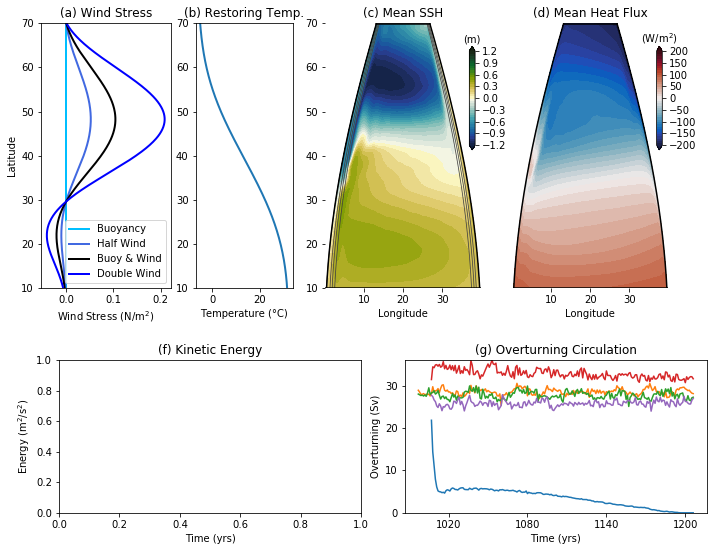

In [50]:
plt.figure(figsize=(10,8))
#Plot wind stress
ax0=plt.axes([0.055, 0.46, 0.18, 0.46])

ax0.plot(0*tau_x_half[:,0],y,label=WindLabel[0],linewidth=2,color=WindColour[0])
ax0.plot(tau_x_half[:,0],y,label=WindLabel[1],linewidth=2,color=WindColour[1])
ax0.plot(tau_x_ref[:,0],y,label=WindLabel[2],linewidth=2,color=WindColour[2])
ax0.plot(tau_x_double[:,0],y,label=WindLabel[3],linewidth=2,color=WindColour[3])
ax0.set_ylim(ymin=10,ymax=70)
ax0.set_ylabel('Latitude')
ax0.set_xlabel('Wind Stress (N/m$^2$)')
ax0.legend()
ax0.set_title('(a) Wind Stress')


#Plot temp restoring
ax0=plt.axes([0.27, 0.46, 0.1344, 0.46])

ax0.plot(SST[:,0],y,linewidth=2)
ax0.set_ylim(ymin=10,ymax=70)
ax0.set_xlabel(u'Temperature (°C)')
ax0.set_title('(b) Restoring Temp.')



# Plot topography and SSH
ax0=plt.axes([0.45, 0.46, 0.216, 0.46])

expt = 'tub-north-tx01-fc02'
variable = 'SSH'
FileName = '/Users/andy/Code/buoyancy-gyres/tub-north-processed/'+expt+'/'+variable+'_averaged.nc'
SSH = xr.open_dataset(FileName).SSH
vlev = np.linspace(-1.2,1.2,41)

X,Y = plot_mercator(ax0,SSH.coords['xh'],SSH.coords['yh'])
ax0.contour(X,Y,-h,3,colors='0.25',linewidths=0.75)
p1=ax0.contourf(X,Y,SSH,levels=vlev,extend='both',cmap=cm.cm.delta)
ax0.set_title('(c) Mean SSH')
ax1 = plt.axes([0.65,0.7,0.008,0.18])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('(m)')

# Plot Heat Flux
ax0=plt.axes([0.71, 0.46, 0.216, 0.46])

variable = 'heat_added'
FileName = '/Users/andy/Code/buoyancy-gyres/tub-north-processed/'+expt+'/'+variable+'_averaged.nc'
HF = xr.open_dataset(FileName).heat_added
vlev = np.linspace(-200,200,41)

X,Y = plot_mercator(ax0,HF.coords['xh'],HF.coords['yh'])
p1=ax0.contourf(X,Y,HF,levels=vlev,extend='both',cmap=cm.cm.balance)
ax0.set_title('(d) Mean Heat Flux')
ax0.set_yticks([])
ax1 = plt.axes([0.91,0.7,0.008,0.18])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('(W/m$^2$)')

## Plot KE evolution
ax0=plt.axes([0.08,0.07,0.42,0.265])

ax0.set_ylabel('Energy (m$^2$/s$^2$)')
ax0.set_xlabel('Time (yrs)')
ax0.set_title('(f) Kinetic Energy')

# Plot overturning evolution
ax0=plt.axes([0.56,0.07,0.42,0.265])
variable = 'vh_rho'



for ekey in Expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.ylim(ymin=0,ymax=36)

ax0.set_title('(g) Overturning Circulation')
ax0.set_ylabel('Overturning (Sv)')
ax0.set_xlabel('Time (yrs)')

plt.savefig('Figure1.png')
plt.savefig('Figure1.pdf')